In [1]:
%load_ext jupyternotify

<IPython.core.display.Javascript object>

In [2]:
from pathlib import Path
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import pandas as pd
from PIL import Image

import torch
from torchvision import transforms
from torchvision.io import read_video


from torch import nn

from fastai.distributed import *
from fastai.vision.all import *

from accelerate import notebook_launcher
from accelerate.utils import write_basic_config

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)

In [5]:
# write_basic_config()

In [6]:
data_dir = Path('data_v4'); assert data_dir.exists()

In [7]:
categories = [Path(cat).stem for cat in os.listdir(data_dir) if cat.endswith('.csv')]

categories, len(categories)

(['into_hole',
  'over',
  'against',
  'inside',
  'outside',
  'out',
  'with',
  'down',
  'against_leaning',
  'on',
  'up',
  'between',
  'all_over',
  'towards',
  'above',
  'among',
  'behind',
  'along',
  'around_surround',
  'below',
  'by',
  'into_crash',
  'from',
  'front',
  'off',
  'beside',
  'around',
  'through',
  'onto',
  'along_position'],
 30)

In [8]:
def noop(x): return x

gonna have to create dataset in the fastai environment

In [9]:
from torch.utils.data import Dataset

class dataset(Dataset):
    def __init__(self, data_dir = data_dir, transform:list = None, y_transform:list = None, frames_per_vid=10, sampling = 'uniform'):
        f'''
        frames_per_vid: how many frames to consider per video for a data sample x. 
                        Per video, frames_per_vid images will be returned, using a sampling. Eg, if sampling = 'uniform', 10 uniformly spaced images will be returned. 
        sampling :      "uniform" by default, other values: "start", "end". if uniform, images will be uniformly returned (including the starting and ending images). If start, the first 10 images will be returned, 
                        if end, from the end
        '''
        super().__init__()
        self.data_dir = Path(data_dir)
        
        self.vocab = [Path(cat).stem for cat in os.listdir(data_dir) if cat.endswith('.csv')]
        self.class_to_index = {cat:i for i,cat in enumerate(self.vocab)}
        self.index_to_class = {self.class_to_index[cat]:cat for cat in self.vocab}
        self.c = len(self.vocab)
        
        self.frame_lim = frames_per_vid #only the last frames_per_vid 
        assert sampling in ('uniform', 'start', 'end'), f"invalid sampling technique. choose from 'uniform', 'start' or 'end'"
        self.sampling = sampling
        self.transforms = list(transform) if transform is not None else [self.sample, lambda x: x.float(), lambda x: torch.transpose(x,1,0)]
        self.y_transforms = list(y_transform) if y_transform is not None else [lambda x: self.class_to_index[x]]
        self.videos = [f for f in get_files(data_dir, extensions=['.mp4']) if f.parent.stem in self.vocab]
        
    def __len__(self): return len(self.videos)
    
    def __getitem__(self, idx):
        x, _, _ = read_video(str(self.videos[idx]), output_format="TCHW")
        x=self.apply_tfm(x,self.transforms)
        
        y=self.apply_tfm(self.videos[idx].parent.stem, self.y_transforms)
        return x,y        
                         
    def apply_tfm(self, x, tfm_list):
        for tfm in tfm_list: x = tfm(x)
        return x
                       
    def sample(self, frames):
        if self.sampling=='uniform': return frames[[int(i*(len(frames)-1)/(self.frame_lim-1)) for i in range(self.frame_lim)]]
        elif self.sampling=='start': return frames[:self.frame_lim]
        elif self.sampling=='end': return frames[len(frames)-self.frame_lim:]
        

In [10]:
data = dataset(data_dir); len(data)

30000

In [11]:
train_split = 0.8
train_ds, test_ds = torch.utils.data.random_split(data, [int(len(data)*train_split), len(data) - int(len(data)*train_split)])

In [31]:
import collection
# counter = collections.Counter([y for x,y in iter(test_ds)])
# counter

Counter({28: 191,
         15: 197,
         1: 212,
         21: 202,
         24: 223,
         16: 192,
         23: 195,
         11: 211,
         5: 212,
         2: 223,
         19: 205,
         26: 187,
         14: 206,
         8: 214,
         27: 204,
         3: 190,
         22: 189,
         6: 178,
         18: 192,
         0: 198,
         29: 171,
         7: 195,
         4: 198,
         12: 213,
         17: 184,
         13: 215,
         9: 191,
         25: 212,
         10: 208,
         20: 192})

In [12]:
from torch.utils.data import DataLoader

In [13]:
def get_batch_size(frames_per_vid, max_effective_batch_size = 100):
    bs_ideal = max_effective_batch_size//frames_per_vid
    #this value can be a batch_size, but we want the nearest lower power of 2 as the batch size for efficiency purposes
    pow=1
    while True:
        if pow*2<=bs_ideal: pow*=2
        else: return pow

In [14]:
#batch_size
bs = get_batch_size(data.frame_lim, max_effective_batch_size = 100)
bs

8

In [15]:
train_dl = DataLoader(train_ds, batch_size =bs , shuffle = True)
test_dl = DataLoader(test_ds, batch_size = 2*bs, shuffle = True)
dls = DataLoaders(train_dl, test_dl)

In [16]:
%time x,y = next(iter(train_dl))
x.shape, y

/home/palaash/miniconda3/envs/prepositions/lib/python3.9/site-packages/torchvision/io/video.py:162: UserWarning: The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.
  warnings.warn("The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.")


CPU times: user 1.63 s, sys: 478 ms, total: 2.11 s
Wall time: 434 ms


(torch.Size([8, 3, 10, 512, 512]), tensor([ 2,  8, 29, 23,  2, 12, 20,  4]))

# Model

What if we used a pretrained model?

In [17]:
import torchvision.models as models
r3d_18 = models.video.r3d_18(weights = 'KINETICS400_V1')
r3d_18.fc = nn.Linear(in_features = 512, out_features=data.c)

In [18]:
r3d_18

VideoResNet(
  (stem): BasicStem(
    (0): Conv3d(3, 64, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3), bias=False)
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (conv2): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1):

UsageError: Line magic function `%%notify` not found.


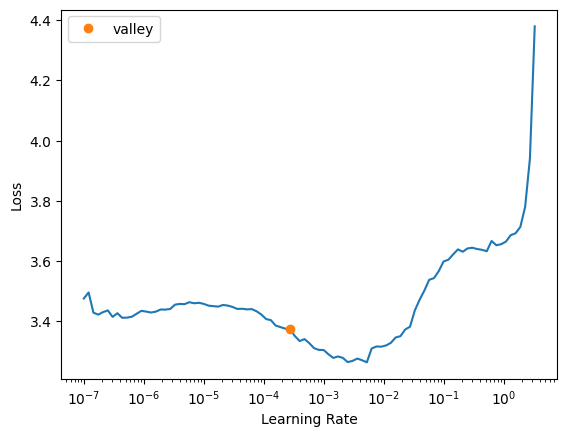

In [19]:
dls = DataLoaders(train_dl, test_dl)
learn = Learner(dls, model = r3d_18.to(device), loss_func = CrossEntropyLossFlat(), metrics = accuracy)
learn.lr_find()
%%notify

We've already estabilished that fit_one_cycle works good, now we need to find a stable paradigm for training the model from scratch

In [20]:
# learn.freeze()
learn.fit_one_cycle(1, 5e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.072540,0.057319,0.966333,2:10:19


In [21]:
%%notify

UsageError: %%notify is a cell magic, but the cell body is empty. Did you mean the line magic %notify (single %)?


In [22]:
learn.save('r3dpretrained_stage1')

Path('models/r3dpretrained_stage1.pth')

In [23]:
learn.load('r3dpretrained_stage1')

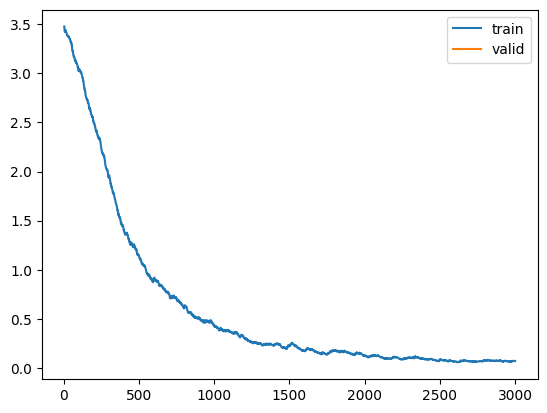

In [24]:
learn.recorder.plot_loss()

In [ ]:
%%notify

In [ ]:
# learn.unfreeze()
# learn.save('r3dpretrained_stage1')
# learn.load('r3dpretrained_stage1')

In [ ]:
# learn.fit_one_cycle(5, 2.5e-4)

In [ ]:
# learn.recorder.losses

In [25]:
test_dl.vocab = [data.vocab] #theres a bug in fastai, it 
interpret = ClassificationInterpretation.from_learner(learn, dl =test_dl)

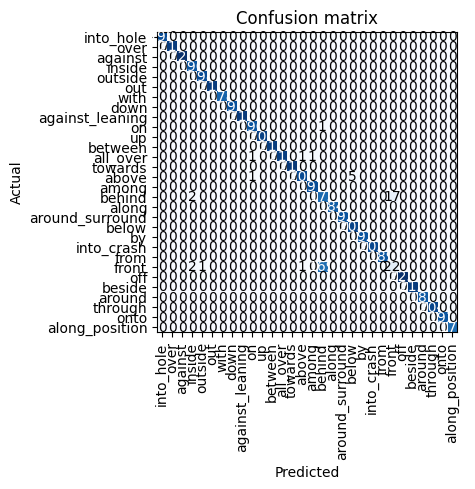

In [26]:
interpret.plot_confusion_matrix()

In [27]:
interpret.most_confused()

[('front', 'behind', 169),
 ('behind', 'front', 17),
 ('above', 'below', 5),
 ('behind', 'inside', 2),
 ('front', 'inside', 2),
 ('on', 'behind', 1),
 ('all_over', 'on', 1),
 ('all_over', 'above', 1),
 ('all_over', 'among', 1),
 ('above', 'on', 1),
 ('front', 'outside', 1),
 ('front', 'above', 1)]

# Modified R3d

## Training iterations

1. only objects, no color. Embedding = 256+256
2. object + color. Embedding = 128 + 128 + 128 +128
3. 

In [ ]:
for module in list(r3d_18.modules()): 
    print('hoya')
    print(module)
